In [1]:
import jax
from jax.random import PRNGKey
from scipy.integrate import solve_ivp
from tqdm.auto import tqdm
from exp.expdata import LorenzExp
import jax.numpy as jnp
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel, PolyLib
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ,SSR,MIOSR
from jsindy.kernels import ConstantKernel, ScalarMaternKernel

jax.config.update('jax_enable_x64',True)


seed = 1234
rkey = PRNGKey(seed)

/home/grisal/github/jsindy/.venv/lib/python3.12/site-packages/sympy2jax/sympy_module.py:291: UserWarning: `equinox.static_field` is deprecated in favour of `equinox.field(static=True)`
  has_extra_funcs: bool = eqx.static_field()


In [2]:
x0 = jnp.array([-8, 8, 27.])
dt = 0.01
t0=0
t1=10.1
n_colloc = 505
expdata = LorenzExp(
    dt = dt,
    initial_state=x0,
    feature_names=['x','y','z'],
    t0=t0,
    t1=t1,
    n_colloc=n_colloc
)

In [3]:
tEndL = jnp.arange(4.0, 11.0, 1.0)
epsL = jnp.arange(0.025, 0.401, 0.025)

tEndL, epsL

(Array([ 4.,  5.,  6.,  7.,  8.,  9., 10.], dtype=float64),
 Array([0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  , 0.225,
        0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  ], dtype=float64))

In [4]:
t_true = expdata.t_true
X_true = expdata.x_true

In [20]:
expdata.t_colloc

Array([-1.98019802e-02,  1.17868930e-04,  2.00377181e-02,  3.99575672e-02,
        5.98774163e-02,  7.97972654e-02,  9.97171146e-02,  1.19636964e-01,
        1.39556813e-01,  1.59476662e-01,  1.79396511e-01,  1.99316360e-01,
        2.19236209e-01,  2.39156058e-01,  2.59075908e-01,  2.78995757e-01,
        2.98915606e-01,  3.18835455e-01,  3.38755304e-01,  3.58675153e-01,
        3.78595002e-01,  3.98514851e-01,  4.18434701e-01,  4.38354550e-01,
        4.58274399e-01,  4.78194248e-01,  4.98114097e-01,  5.18033946e-01,
        5.37953795e-01,  5.57873645e-01,  5.77793494e-01,  5.97713343e-01,
        6.17633192e-01,  6.37553041e-01,  6.57472890e-01,  6.77392739e-01,
        6.97312588e-01,  7.17232438e-01,  7.37152287e-01,  7.57072136e-01,
        7.76991985e-01,  7.96911834e-01,  8.16831683e-01,  8.36751532e-01,
        8.56671381e-01,  8.76591231e-01,  8.96511080e-01,  9.16430929e-01,
        9.36350778e-01,  9.56270627e-01,  9.76190476e-01,  9.96110325e-01,
        1.01603017e+00,  

In [21]:
cutoff = 1
signal_power = jnp.std(X_true)
for t_end in tqdm(tEndL[:cutoff],leave=True):
    for noise_ratio in tqdm(epsL[:cutoff], leave=False):
        t_end_idx = int(t_end // dt)
        X_train = X_true[:t_end_idx]
        t_train = t_true[:t_end_idx]

        eps = noise_ratio*signal_power


        noise = eps*jax.random.normal(rkey, X_train.shape)

        X_train += noise

        kernel = (
            ConstantKernel(variance = 5.)
            +ScalarMaternKernel(p = 5,variance = 10., lengthscale=3,min_lengthscale=0.05)
        )   
        trajectory_model = CholDataAdaptedRKHSInterpolant(kernel=kernel)
        dynamics_model = FeatureLinearModel(
            reg_scaling = 1.,
            feature_map=PolyLib(degree=2)
        )
        optsettings = LMSettings(
            max_iter = 1000,
            show_progress=True,
            no_tqdm=False,
            min_alpha = 1e-16,
            init_alpha = 5.,
            print_every = 100,
        )
        data_weight =  100
        colloc_weight = 1000
        sparsifier = pySindySparsifier(
            STLSQ(threshold = 0.5,alpha = 0.3)
            )
        # sparsifier = pySindySparsifier(EnsembleOptimizer(STLSQ(threshold = 0.5,alpha = 0.1),bagging=True,n_models = 100))

        # sparsifier = pySindySparsifier(
        #     MIOSR(target_sparsity = 7,alpha = 0.1)
        #     )


        optimizer = AlternatingActiveSetLMSolver(
                beta_reg=1e-1,
                solver_settings=optsettings,
                fixed_colloc_weight=colloc_weight,
                fixed_data_weight=data_weight,
                sparsifier = sparsifier
                )

        model = JSINDyModel(
            trajectory_model=trajectory_model,
            dynamics_model=dynamics_model,
            optimizer=optimizer,
            feature_names=expdata.feature_names
        )

        model.fit(t_train, X_train,)

        

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(0.10929162, dtype=float64), 'data_weight': 100, 'colloc_weight': 1000}
Warm Start


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 6.448e+03, gradnorm = 3.953e+05, alpha = 4.167, improvement_ratio = 0.9998
Iteration 1, loss = 6.399e+03, gradnorm = 9.916e+03, alpha = 3.472, improvement_ratio = 0.9973
Iteration 2, loss = 6.384e+03, gradnorm = 2.748e+03, alpha = 2.894, improvement_ratio = 1.0
Iteration 3, loss = 6.376e+03, gradnorm = 548.7, alpha = 2.411, improvement_ratio = 1.0
Iteration 4, loss = 6.372e+03, gradnorm = 270.7, alpha = 2.009, improvement_ratio = 0.9994
Iteration 5, loss = 6.37e+03, gradnorm = 144.9, alpha = 1.674, improvement_ratio = 0.9983
Iteration 51, loss = 6.369e+03, gradnorm = 1.211e-05, alpha = 69.44, improvement_ratio = inf
Model after smooth warm start
(x)' = -1.805 1 + -9.315 x + 9.647 y + 0.042 z + -0.024 x^2 + 0.017 x y + -0.016 x z + 0.001 y^2 + 0.009 y z + 0.001 z^2
(y)' = 2.138 1 + 27.333 x + -0.687 y + -0.203 z + -0.040 x^2 + 0.029 x y + -0.981 x z + -0.003 y^2 + -0.009 y z + 0.006 z^2
(z)' = 0.640 1 + 0.143 x + -0.038 y + -2.829 z + -0.041 x^2 + 1.035 x y + -0.004 

In [22]:
# epsL * signal_power

In [23]:
model.print()
expdata.print()

(x)' = -9.945 x + 9.999 y
(y)' = 27.851 x + -0.988 y + -0.995 x z
(z)' = -2.668 z + 1.002 x y
(x)' = -10.000 x + 10.000 y
(y)' = 28.000 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y


In [24]:
print(model)


--------Trajectory Model--------

MLE Adapted Cholesky Parametrized RKHS Trajectory Model
kernel: 181.229 + 88.51Matern(5,0.16)
derivative_orders: (0, 1)
nugget: 1e-08


--------Feature Library---------
degree: 2
include_bias: True
include_interaction: True
interaction_only: False
order: C

--------Optimizer Setup--------

Alternating Active Set Optimizer
beta_reg: 0.1,
sparsifier: STLSQ(alpha=0.3, threshold=0.5)
data_weight: 100
colloc_weight: 1000




In [25]:
model.theta.shape, expdata.true_coeff.T.shape

((10, 3), (10, 3))

In [26]:
a = model.theta
b = expdata.true_coeff.T

In [27]:
# a = a.at[0,-1].set(0)

In [28]:
a

Array([[ 0.        ,  0.        ,  0.        ],
       [-9.94534853, 27.85144781,  0.        ],
       [ 9.99935128, -0.98796143,  0.        ],
       [ 0.        ,  0.        , -2.66772572],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.00209033],
       [ 0.        , -0.99532729,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]], dtype=float64)

In [29]:
b

Array([[  0.        ,   0.        ,   0.        ],
       [-10.        ,  28.        ,   0.        ],
       [ 10.        ,  -1.        ,   0.        ],
       [  0.        ,   0.        ,  -2.66666667],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   1.        ],
       [  0.        ,  -1.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ]], dtype=float64)

In [30]:
jnp.log10(jnp.sqrt(jnp.sum((a-b)**2)) / jnp.sqrt(jnp.sum(b**2)))

Array(-2.29778285, dtype=float64)

In [31]:
jnp.log10(0.000001)

Array(-6., dtype=float64)

In [32]:
X_pred = model.predict_state(t_train)

In [33]:
time_idices = [400, 500, 600, 700,800,900,1000]


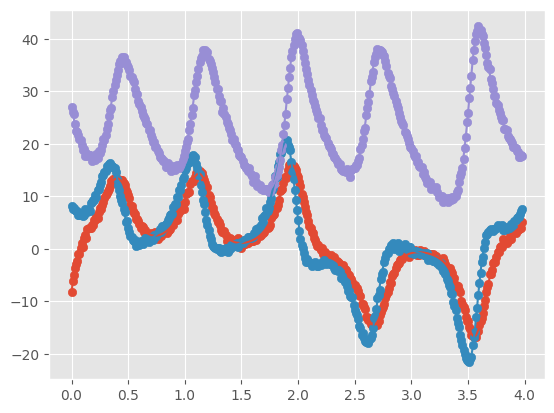

In [34]:
for idx in range(3):
    plt.plot(t_train, X_pred[:,idx])
    plt.scatter(t_train, X_train[:,idx])
    # plt.show()

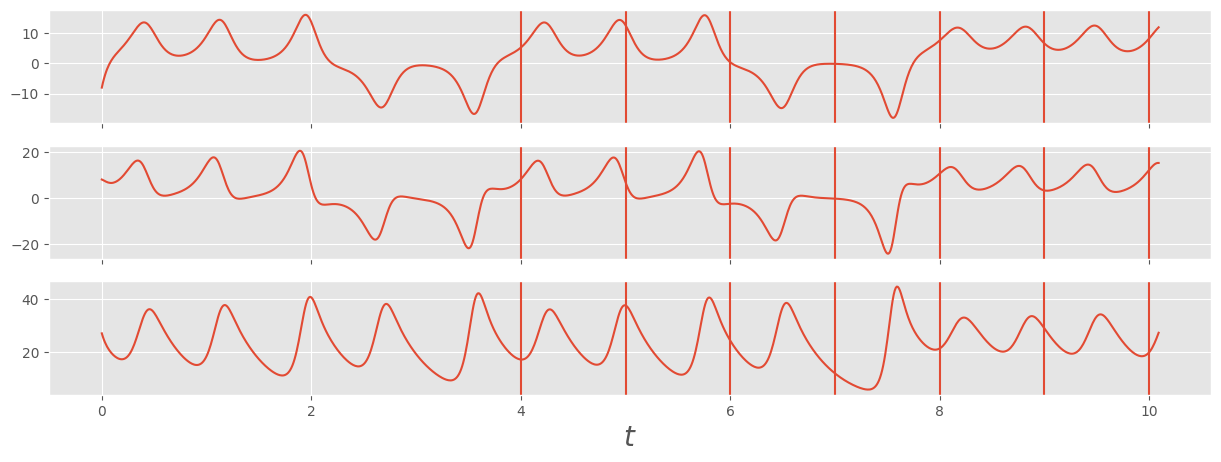

In [19]:
fig, axs = plt.subplots(3,1,figsize=(15,5),sharex=True)
axs = axs.flatten()
for idx, ax in enumerate(axs):
    ax.plot(t_true, X_true[:,idx])
    for trial_time in tEndL:
        ax.axvline(trial_time)
    if idx == len(axs)-1:
        ax.set_xlabel(r"$t$", size=20)
plt.show()

converted code

In [ ]:
yeehaw
"""
lorenz_sindy_mwe.py
Minimal Working Example (MWE) ported from the MATLAB script to Python.

Requirements:
    pip install numpy scipy scikit-learn tqdm

Runs:
    python lorenz_sindy_mwe.py
"""
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
from tqdm import trange
import os

# -----------------------
# Problem / experiment parameters
# -----------------------
epsL = np.arange(0.025, 0.401, 0.025)   # noise ratios
tEndL = np.arange(4.0, 11.0, 1.0)       # simulation times: 4..10
nTest1 = 20    # SINDy repeats
nTest2 = 64    # Ensemble repeats

# SINDy / ensemble hyperparams
lambda_alpha = 0.2   # Lasso alpha (acts like lambda)
nEnsembles = 100
ensembleT = 0.6      # threshold on inclusion probability

# Lorenz parameters and initial condition
sigma_l, rho_l, beta_l = 10.0, 28.0, 8.0/3.0
ode_params = (sigma_l, rho_l, beta_l)
x0 = np.array([-8.0, 8.0, 27.0])
dt = 0.01

rng = np.random.default_rng(1)

# -----------------------
# helper functions
# -----------------------
def lorenz(t, x, params):
    s, r, b = params
    dx = np.empty_like(x)
    dx[0] = s * (x[1] - x[0])
    dx[1] = x[0] * (r - x[2]) - x[1]
    dx[2] = x[0] * x[1] - b * x[2]
    return dx

def build_theta(X, polys=(1,2)):
    # X shape: (n_time, n_state)  -> build library rows per time
    # library: constant, x, y, z, x^2, xy, xz, y^2, yz, z^2  for polys up to 2
    nT, nState = X.shape
    assert nState == 3
    x = X[:,0]; y = X[:,1]; z = X[:,2]
    cols = [np.ones(nT), x, y, z]
    if 2 in polys:
        cols += [x**2, x*y, x*z, y**2, y*z, z**2]
    Theta = np.vstack(cols).T  # (nT, nFeatures)
    return Theta

def central_diff_matrix(n, dt):
    # returns matrix D of shape (n, n) that approximates d/dt via 2nd-order central diff with one-sided ends
    D = np.zeros((n, n))
    if n < 4:
        # fallback to simple diff
        for i in range(n-1):
            D[i,i] = -1.0/dt; D[i,i+1] = 1.0/dt
        D[n-1, n-2] = -1.0/dt; D[n-1, n-1] = 1.0/dt
        return D
    # first point: forward-biased 3rd order
    D[0,0] = -11/6; D[0,1]=3; D[0,2]=-1.5; D[0,3]=1/3
    D[0,:] /= dt
    # interior central
    for i in range(1,n-1):
        D[i,i-1] = -0.5; D[i,i+1] = 0.5
        D[i,:] /= dt
    # last point: backward-biased 3rd order
    D[-1,-1] = 11/6; D[-1,-2] = -3; D[-1,-3] = 1.5; D[-1,-4] = -1/3
    D[-1,:] /= dt
    return D

def fit_sindy_lasso(Theta, dX, alpha=lambda_alpha, max_iter=5000):
    # Fit Lasso separately for each state equation (columns of dX)
    # Theta: (nT, nFeat) ; dX: (nT, nState)
    nFeat = Theta.shape[1]
    nState = dX.shape[1]
    Xi = np.zeros((nFeat, nState))
    model = Lasso(alpha=alpha, fit_intercept=False, max_iter=max_iter)
    for j in range(nState):
        model.fit(Theta, dX[:, j])
        Xi[:, j] = model.coef_
    return Xi

# -----------------------
# compute "true" weights from noise-free integration (acts like getTrueWeights)
# -----------------------
t_full = np.arange(dt, 10.0 + dt/2, dt)
sol = solve_ivp(lambda t, y: lorenz(t, y, ode_params), (t_full[0], t_full[-1]), x0, t_eval=t_full, rtol=1e-10, atol=1e-10)
X_true = sol.y.T            # (nT, 3)
D = central_diff_matrix(X_true.shape[0], dt)
dX_true = D @ X_true        # approximate derivatives
Theta_true = build_theta(X_true, polys=(1,2))
# true weights via least-squares (pseudo-inverse)
true_nz_weights = np.linalg.lstsq(Theta_true, dX_true, rcond=None)[0]  # shape (nFeat, 3)

signal_power = np.std(X_true)

# -----------------------
# storage arrays
# -----------------------
n_eps = len(epsL); n_tend = len(tEndL)
nWrongTermsS = np.zeros((n_eps, n_tend, nTest1), dtype=int)
modelErrorS = np.zeros_like(nWrongTermsS, dtype=float)
successS = np.zeros_like(nWrongTermsS, dtype=bool)

nWrongTermsE = np.zeros((n_eps, n_tend, nTest2), dtype=int)
modelErrorE = np.zeros_like(nWrongTermsE, dtype=float)
successE = np.zeros_like(nWrongTermsE, dtype=bool)

# -----------------------
# Main loops
# -----------------------
print("Starting simulation loops...")
for ieps in range(n_eps):
    noise_ratio = epsL[ieps]
    for idt in range(n_tend):
        tEnd = float(tEndL[idt])
        tspan = np.arange(dt, tEnd + dt/2, dt)
        sol = solve_ivp(lambda t, y: lorenz(t, y, ode_params), (tspan[0], tspan[-1]), x0, t_eval=tspan, rtol=1e-10, atol=1e-10)
        X = sol.y.T  # (nT, 3)
        # set reproducible RNG for each loop similar to rng(1,'twister')
        local_rng = np.random.default_rng(1)

        # ----- SINDy single-run experiments -----
        for ii in range(nTest1):
            sigma = noise_ratio * signal_power
            noise = local_rng.normal(0.0, sigma, size=X.shape)
            Xobs = X + noise
            Theta_0 = build_theta(Xobs, polys=(1,2))
            Dmat = central_diff_matrix(Xobs.shape[0], dt)
            dXobs = Dmat @ Xobs
            Xi_hat = fit_sindy_lasso(Theta_0, dXobs, alpha=lambda_alpha)
            # metrics
            nz_true = (np.abs(true_nz_weights) > 1e-12).astype(int)
            nz_hat = (np.abs(Xi_hat) > 1e-12).astype(int)
            nWrongTermsS[ieps, idt, ii] = np.sum(np.abs(nz_true - nz_hat))
            modelErrorS[ieps, idt, ii] = np.linalg.norm(Xi_hat - true_nz_weights, ord='fro') / np.linalg.norm(true_nz_weights, ord='fro')
            successS[ieps, idt, ii] = int(np.sum(np.abs(nz_true - nz_hat)) == 0)

        # ----- Ensemble experiments (bootstrap on data) -----
        for ii in range(nTest2):
            sigma = noise_ratio * signal_power
            noise = local_rng.normal(0.0, sigma, size=X.shape)
            Xobs = X + noise
            Theta_0 = build_theta(Xobs, polys=(1,2))
            Dmat = central_diff_matrix(Xobs.shape[0], dt)
            dXobs = Dmat @ Xobs

            # bootstrap ensemble: sample with replacement along time indices
            nT = Theta_0.shape[0]
            Xi_ensembles = np.zeros((Theta_0.shape[1], Xobs.shape[1], nEnsembles))
            nz_ensembles = np.zeros_like(Xi_ensembles, dtype=int)
            for e in range(nEnsembles):
                idx = local_rng.integers(0, nT, size=nT)  # bootstrap indices
                Theta_bs = Theta_0[idx, :]
                dX_bs = dXobs[idx, :]
                Xi_e = fit_sindy_lasso(Theta_bs, dX_bs, alpha=lambda_alpha)
                Xi_ensembles[:, :, e] = Xi_e
                nz_ensembles[:, :, e] = (np.abs(Xi_e) > 1e-12).astype(int)

            # inclusion probability per coefficient
            incl_prob = nz_ensembles.mean(axis=2)  # (nFeat, nState)
            mask = (incl_prob >= ensembleT)

            Xi_mean = Xi_ensembles.mean(axis=2)
            Xi_median = np.median(Xi_ensembles, axis=2)

            # threshold small-prob coeffs to zero
            Xi_mean[~mask] = 0.0
            Xi_median[~mask] = 0.0

            # choose median as ensemble estimator (like XiMedian in MATLAB)
            Xi_est = Xi_median

            nz_true = (np.abs(true_nz_weights) > 1e-12).astype(int)
            nz_hat = (np.abs(Xi_est) > 1e-12).astype(int)
            nWrongTermsE[ieps, idt, ii] = np.sum(np.abs(nz_true - nz_hat))
            modelErrorE[ieps, idt, ii] = np.linalg.norm(Xi_est - true_nz_weights, ord='fro') / np.linalg.norm(true_nz_weights, ord='fro')
            successE[ieps, idt, ii] = int(np.sum(np.abs(nz_true - nz_hat)) == 0)

        print(f"eps idx {ieps+1}/{n_eps}, tEnd idx {idt+1}/{n_tend}")

# -----------------------
# Save results
# -----------------------
outdir = "results_py"
os.makedirs(outdir, exist_ok=True)
np.savez(os.path.join(outdir, "Lorenz_simOutS_MWE.npz"),
         nWrongTermsS=nWrongTermsS, modelErrorS=modelErrorS, successS=successS,
         epsL=epsL, tEndL=tEndL)
np.savez(os.path.join(outdir, "Lorenz_simOutE_MWE.npz"),
         nWrongTermsE=nWrongTermsE, modelErrorE=modelErrorE, successE=successE,
         epsL=epsL, tEndL=tEndL)

print("Done. Results saved to 'results_py/'")
